In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5   ZBTB8B  \
Patient_ID                                            ...                     
55_control    1.000000  0.363133  0.374212  0.611161  ...      0.0  0.71077   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...      0.0  0.00000   
72_control    0.648401  0.134017  0.200420  0.679453  ...      0.0  0.00000   
120_control   0.579519  0.248934  0.759250  0.755407  ...      0.0  0.00000   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...      0.0  0.00000   
...                ...       ...       ...       ...  ...      ...      ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...      0.0  0.00000   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...      0.0  0.00000   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...      0.0  0.00000   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...      0.0  0.00000   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...      0.0  0.00000   

              EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  IGLV2_5  C6orf106  \
Patient_ID                                                                     
55_control          0.0       0.564155      0.0  0.410548      0.0  0.466889   
168_CD_plain        0.0       0.619646      0.0  0.576526      0.0  0.247033   
72_control          0.0       0.978062      0.0  0.322280      0.0  0.809681   
120_control         0.0       0.630496      0.0  0.633583      0.0  0.568599   
258_CD_plain        0.0       0.575404      0.0  0.754246      0.0  0.349619   
...                 ...            ...      ...       ...      ...       ...   
15_CD_plain         0.0       0.424522      0.0  0.647019      0.0  0.358576   
182_CD_plain        0.0       0.643529      0.0  0.676222      0.0  0.534238   
164_CD_plain        0.0       0.592646      0.0  0.784037      0.0  0.401977   
53_CD_plain         0.0       0.503764      0.0  0.726674      0.0  0.482674   
97_CD_plain         0.0       0.480415      0.0  0.702185      0.0  0.809611   

              RPL7AP54     LCE2A  
Patient_ID                        
55_control         0.0  1.000000  
168_CD_plain       0.0  0.008198  
72_control         0.0  0.618383  
120_control        0.0  0.208173  
258_CD_plain       0.0  0.000000  
...                ...       ...  
15_CD_plain        0.0  0.000000  
182_CD_plain       0.0  0.646805  
164_CD_plain       0.0  0.232271  
53_CD_plain        0.0  0.000000  
97_CD_plain        0.0  0.461059  

[182 rows x 220 columns]

In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...      0.0   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...      0.0   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...      0.0   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...      0.0   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...      0.0   
...                     ...       ...       ...       ...  ...      ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...      0.0   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...      0.0   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...      0.0   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...      0.0   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
253_CD_plain          0.0        0.0       0.790435      0.0  0.849076   
105_CD_plain          0.0        0.0       0.917793      0.0  0.604771   
2_CD_plain            0.0        0.0       0.063827      0.0  0.703353   
184_CD_plain          0.0        0.0       0.650608      0.0  0.749070   
312_CD_plain          0.0        0.0       0.481745      0.0  0.717561   
...                   ...        ...            ...      ...       ...   
107_CD_plain          0.0        0.0       0.486418      0.0  0.625206   
279_CD_plain          0.0        0.0       0.217050      0.0  0.889784   
179_CD_plain          0.0        0.0       0.492356      0.0  0.744538   
70_CD_deep_ulcer      0.0        0.0       0.518714      0.0  0.461913   
256_CD_deep_ulcer     0.0        0.0       0.591308      0.0  0.713509   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
253_CD_plain           0.0  0.686223       0.0  0.395101  
105_CD_plain           0.0  0.668052       0.0  0.671177  
2_CD_plain             0.0  0.826523       0.0  0.000000  
184_CD_plain           0.0  0.548091       0.0  0.134641  
312_CD_plain           0.0  0.541235       0.0  0.000000  
...                    ...       ...       ...       ...  
107_CD_plain           0.0  0.722622       0.0  0.000000  
279_CD_plain           0.0  0.514313       0.0  0.000000  
179_CD_plain           0.0  0.494143       0.0  0.165054  
70_CD_deep_ulcer       0.0  0.528017       0.0  0.000000  
256_CD_deep_ulcer      0.0  0.587452       0.0  0.000000  

[78 rows x 220 columns]

In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('../data/models/cd_encoder')

In [7]:
compound_model.summary()

NameError: name 'compound_model' is not defined

## SHAP evaluation

In [109]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [111]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[18])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [112]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [113]:
# shap_values

## Independent - 41

In [360]:
idx = 41

In [361]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [362]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [363]:

with open("../data/models/shap/new_ind_41_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [364]:
# shap_values[0][0].shape

In [365]:
shap_values = shap_values[0]

In [366]:
# shap_values[0] *= 100000

In [367]:
shap_values

[array([[  0.        ,   0.36377985,  -3.38823455,  -1.65810121,
          -6.41540934,  23.62427552,  36.34033709,  -2.35105194,
           0.17702226,  -0.22856192,   0.41878641,   4.39065958,
           0.5731999 ,   2.59976048,   8.82834226,  -9.29332447,
           3.99910909,  -6.20106717,   0.        ,  -1.1297361 ,
           4.70371605,   0.98812058,  -5.47515742,  21.04071315,
         -10.11652625,  -2.67100822,  -7.91654057,  -2.75045984,
           0.        ,  -5.95232344,   2.31987574,  -7.22004782,
          16.3035982 ,   6.77509054,  -3.6221424 , -15.77251824,
         -10.40570786, -20.1882536 ,   9.93644853,  -5.77607049,
           0.        , -14.59889091,   9.30422227,  -7.3505852 ,
          -7.05174449,  -0.22632159,   0.32105658,   6.96071238,
         -14.74456036,  -7.01640238,  16.54663857,  -7.38412032,
           0.        ,  -7.61219835,  22.42568535, -14.7682461 ,
         -12.59374413,   0.        ,   0.        ,   0.        ,
          -6.95288349,  -

In [368]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [369]:

patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
260_CD_deep_ulcer     0.0        0.0       0.652111      0.0  0.876483   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
260_CD_deep_ulcer      0.0  0.551273       0.0  0.262322  

[1 rows x 220 columns]

In [370]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.25365522e-20 8.38401766e-02 9.16159823e-01]
Predicted class: 2


#### Control

In [371]:
import shap

In [372]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [373]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [374]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [375]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

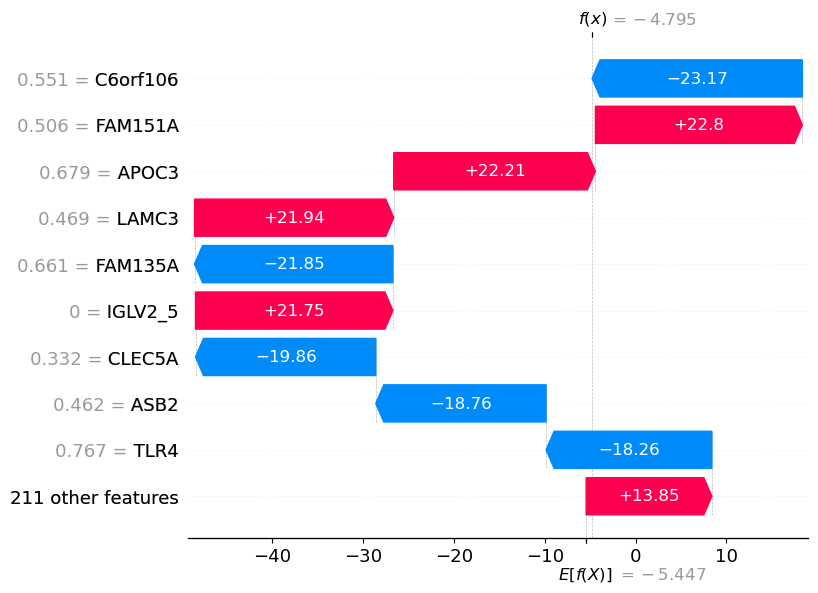

In [376]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 41

In [379]:
idx = 41

In [380]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [381]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [382]:

with open("../data/models/shap/new_fd_41_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [383]:
# shap_values[0][0].shape

In [384]:
shap_values = shap_values[0]

In [385]:
# shap_values[0] *= 100000

In [386]:
shap_values

[array([[ 2.27311993e+00,  0.00000000e+00, -2.20935978e+00,
          4.57051982e-01, -6.62995501e+00,  3.38174932e+01,
          2.36796034e+01,  7.14421368e-01, -6.96722337e+00,
          1.14707628e+01,  5.19196722e+00,  4.34839063e+00,
         -1.14146824e+01,  0.00000000e+00,  1.37405339e+01,
          0.00000000e+00,  0.00000000e+00, -1.39197284e+00,
          1.04848218e+01, -1.24684573e+00, -1.87043047e+00,
          5.13776685e+00,  5.40000760e+00,  5.38008768e+00,
         -8.02071087e+00,  8.83726380e+00, -8.03628849e+00,
         -1.06008485e+01, -1.60263442e+01, -1.40620924e+01,
          4.98098770e+00, -2.65568243e-01, -2.23683854e-01,
          2.08681183e+01, -2.12000873e+00,  0.00000000e+00,
          8.65984915e-01, -2.41321242e+01,  3.58464235e+00,
         -2.31778290e+00, -5.64613445e+00,  1.19582943e+00,
          8.31237784e+00, -5.38185919e+00, -2.16417595e+00,
         -1.63640723e+00,  2.22566893e+00,  2.37310177e-02,
         -3.61443371e+01, -6.73120987e+0

In [387]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [388]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
260_CD_deep_ulcer     0.0        0.0       0.652111      0.0  0.876483   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
260_CD_deep_ulcer      0.0  0.551273       0.0  0.262322  

[1 rows x 220 columns]

In [389]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.25365522e-20 8.38401766e-02 9.16159823e-01]
Predicted class: 2


#### Control

In [390]:
import shap

In [391]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [392]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [393]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [394]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

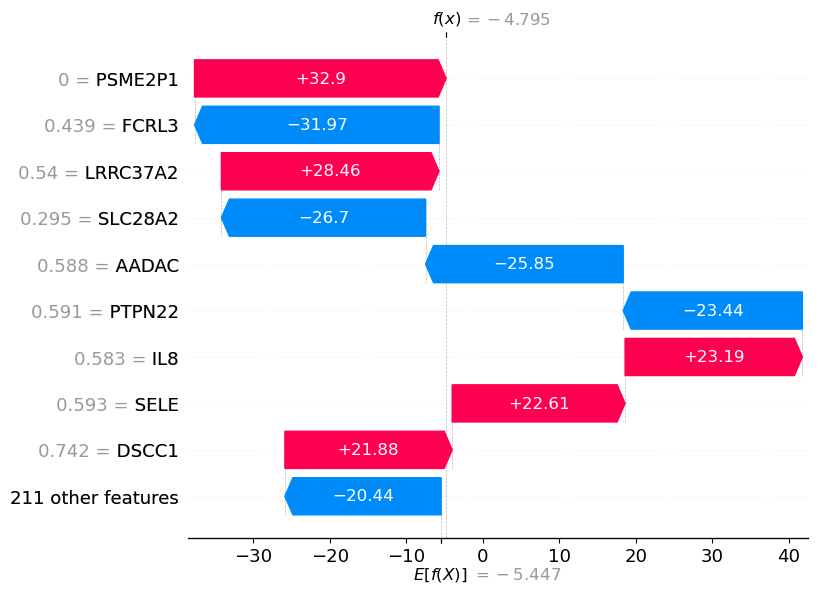

In [395]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 18

In [396]:
idx = 18

In [397]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [398]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [399]:

with open("../data/models/shap/new_fd_18_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [400]:
# shap_values[0][0].shape

In [401]:
shap_values = shap_values[0]

In [402]:
# shap_values[0] *= 100000

In [403]:
shap_values

[array([[-21.48949251,   0.        , -32.91308936,   0.        ,
         -19.82997737,  96.79843542, 106.24862918,   0.        ,
          -3.75386069, -14.92161394,   8.28786948,  23.12987792,
           0.        ,   0.        ,  16.9607068 , -11.33842576,
          10.85197164, -14.88497512,   0.        ,   0.        ,
          26.87193281,   0.        ,   0.        ,  54.09096169,
         -21.40382527, -21.13512328, -23.92248568, -15.27393361,
           0.        , -30.65829046,   2.9981587 ,  -7.34769636,
          33.36853898,  17.02253624, -24.40053367, -42.51927019,
         -29.73296701, -69.62402258,  27.58471528, -16.2187749 ,
           0.        ,   0.        ,  22.03312551, -20.08886894,
          -9.0741886 ,  -4.35155229,   9.64616357,  -3.01317725,
         -55.50217355, -21.90987535,  40.46108038, -16.4471165 ,
           0.        , -23.18627534,  63.13051195, -50.77821962,
         -32.59767556,   1.58224478,   0.        ,   0.        ,
         -23.03155458, -2

In [404]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [405]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...      0.0   

                  ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                              
46_CD_deep_ulcer     0.0        0.0       0.360556      0.0  0.748095   

                  IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                            
46_CD_deep_ulcer      0.0  0.675387       0.0    0.0  

[1 rows x 220 columns]

In [406]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.71991469e-53 1.81023097e-03 9.98189769e-01]
Predicted class: 2


#### Control

In [407]:
import shap

In [408]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [409]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [410]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [411]:
# deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

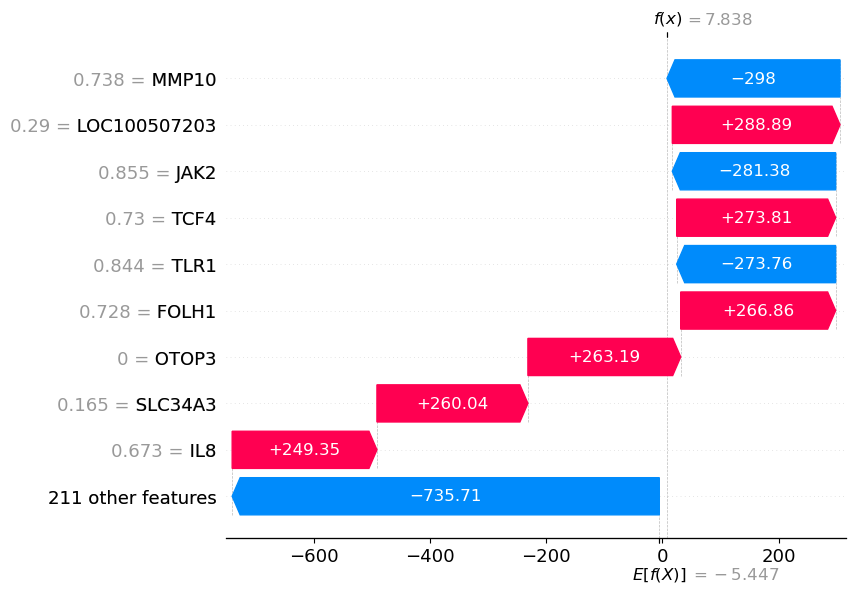

In [412]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 18

In [446]:
idx = 18

In [447]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [448]:


with open("../data/models/shap/new_ind_18_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [449]:
shap_values = shap_values[0]

In [450]:
shap_values

[array([[-3.45821126e+01,  6.74026914e+00, -1.66420530e+01,
         -1.44355106e+00, -1.05587107e+01,  8.89987645e+01,
          1.17770765e+02, -7.88761088e+00,  2.70385793e+00,
          0.00000000e+00,  0.00000000e+00,  3.01337139e+01,
          0.00000000e+00,  0.00000000e+00,  1.24767176e+01,
         -2.20006895e+01,  0.00000000e+00, -1.98540813e+01,
         -9.26731698e+00, -1.16368671e+01,  3.26259119e+01,
         -7.91365238e+00,  0.00000000e+00,  6.10619672e+01,
         -3.23753825e+01, -1.11255870e+01, -2.35555928e+01,
         -2.48473617e+01,  1.03696635e+01, -1.91172886e+01,
          0.00000000e+00, -2.18496500e+01,  4.87323831e+01,
          2.74741410e+01, -2.09318534e+01, -4.61256638e+01,
         -3.31483138e+01, -7.62586998e+01,  3.74836647e+01,
         -1.25792864e+01, -2.62942580e-01, -2.55762853e+01,
          3.60433453e+01, -2.17539431e+01, -9.70449707e+00,
         -1.04607846e-01,  0.00000000e+00,  2.79081210e+01,
         -5.60377909e+01, -2.30079166e+0

In [451]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [452]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...      0.0   

                  ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                              
46_CD_deep_ulcer     0.0        0.0       0.360556      0.0  0.748095   

                  IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                            
46_CD_deep_ulcer      0.0  0.675387       0.0    0.0  

[1 rows x 220 columns]

In [453]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:", np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.71991469e-53 1.81023097e-03 9.98189769e-01]
Predicted class: 2


#### Control

In [454]:
import shap

In [455]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [456]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [457]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [458]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
#deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

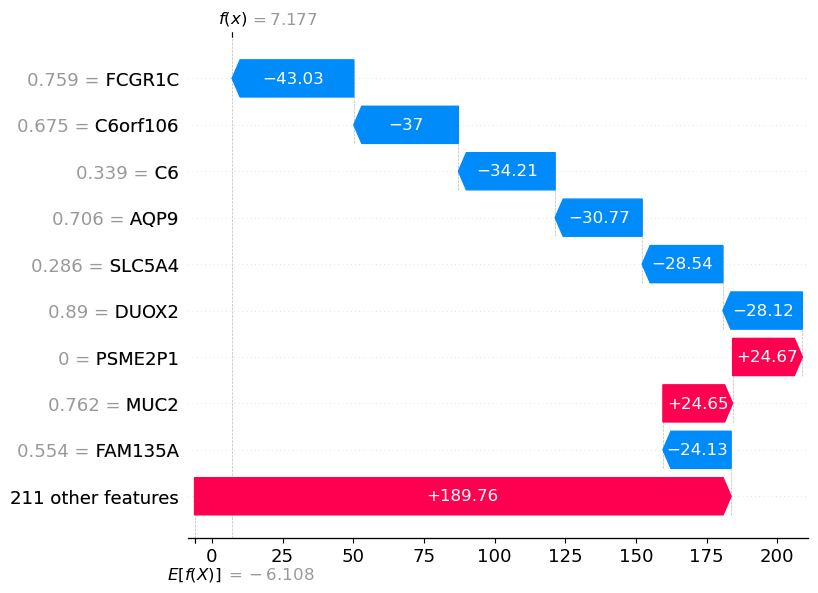

In [459]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [460]:
# control
explanation = objects.get_explanation(values=shap_values[0][0], 
                                              base_values=explainer.expected_value[0], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

getting explanation


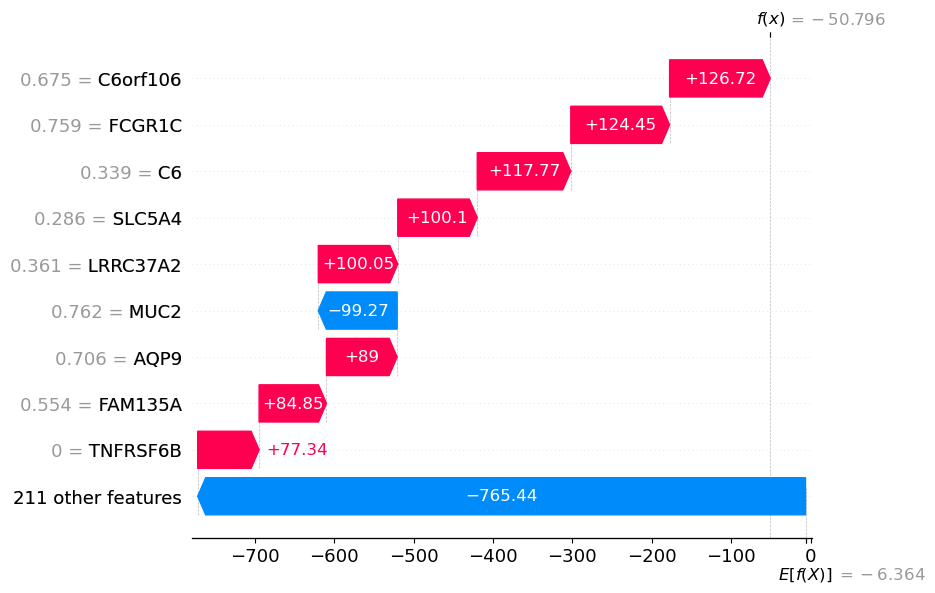

In [461]:
shap.waterfall_plot(explanation)

## Independent - 77

In [296]:
idx = 77

In [297]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [298]:


with open("../data/models/shap/new_ind_77_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [299]:
shap_values = shap_values[0]

In [300]:
shap_values

[array([[  0.        ,  -0.36534849,  -8.05831297,  -5.78204161,
          -2.83889054,  10.18765614,   8.16306332,   0.        ,
           0.37929306,  -1.53386164,   0.        ,  -0.18952567,
          -1.08030822,   0.        ,  10.45792507,   0.        ,
           4.55011796,  -7.07985177,   0.        ,  -1.42523469,
           0.39187351,  -3.53300481,   2.46473123,   9.78967574,
          -3.7961999 ,  -2.2986408 ,  -4.1697161 ,   5.03034257,
           1.50015878,   1.20455587,   0.7405645 ,  -3.58496785,
           8.61096339,   4.95342083,  -2.9700925 ,  -2.13637972,
          -4.27223639,  -8.7042977 ,   1.36137362,  -3.55724894,
          -2.63506687,  -2.58028254,   5.13276932,  -4.10452095,
           0.        ,   0.06187612,   0.        ,   9.1735685 ,
          -9.56984418,   3.93527182,   8.97275681,  -3.26001007,
          -7.79792517,  -4.25366418,   6.64492012,   0.        ,
          -8.01021575,   0.        ,  -1.76094136,  -4.01021164,
          -3.67649766,  -

In [301]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [302]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...  C1QTNF5  ZBTB8B  \
Patient_ID                                           ...                    
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...      0.0     0.0   

                   EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  IGLV2_5  \
Patient_ID                                                                
256_CD_deep_ulcer        0.0       0.591308      0.0  0.713509      0.0   

                   C6orf106  RPL7AP54  LCE2A  
Patient_ID                                    
256_CD_deep_ulcer  0.587452       0.0    0.0  

[1 rows x 220 columns]

In [303]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.54192605e-15 3.11153570e-01 6.88846430e-01]
Predicted class: 2


#### Control

In [304]:
import shap

In [305]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [306]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [307]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [308]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

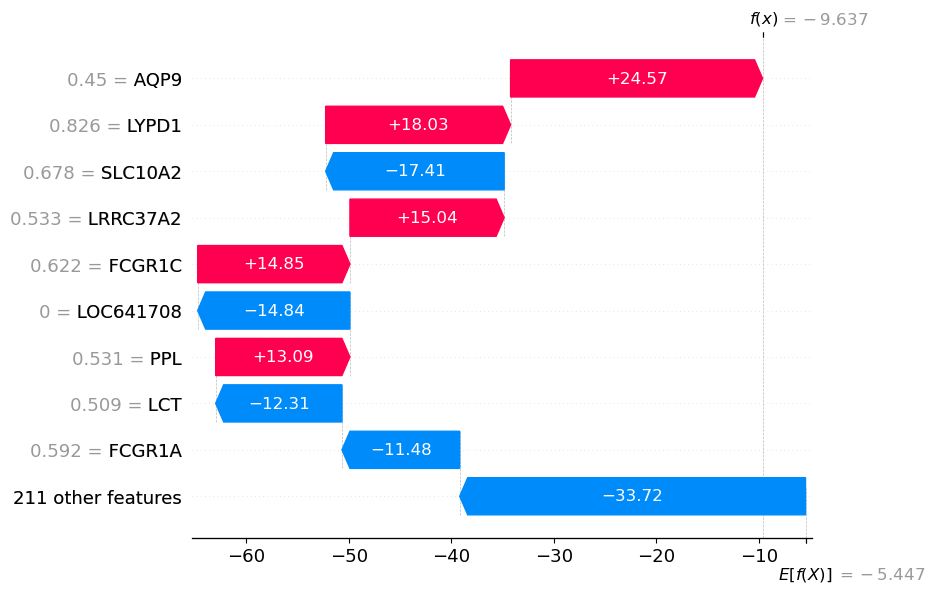

In [309]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 77

In [413]:
idx = 77

In [414]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [415]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [416]:

with open("../data/models/shap/new_fd_77_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [417]:
# shap_values[0][0].shape

In [418]:
shap_values = shap_values[0]

In [419]:
# shap_values[0] *= 100000

In [420]:
shap_values

[array([[ 0.00000000e+00, -3.76976686e-01, -3.69531317e+00,
          0.00000000e+00, -3.46444180e+00,  1.16453262e+01,
          1.30611064e+01,  0.00000000e+00,  0.00000000e+00,
         -1.72846052e+00,  1.30888130e+00,  5.87371017e+00,
          9.74873692e-01,  6.18322848e-01,  9.74368640e+00,
          0.00000000e+00,  1.48603949e+00, -2.60188931e+00,
         -2.50935217e-01,  2.59269589e-01,  2.92762768e-01,
          3.33017570e+00,  1.82803646e+00,  4.41752169e+00,
         -4.40851700e-03, -4.53405582e+00, -4.38918922e+00,
          0.00000000e+00,  2.80970552e-03, -8.85217501e+00,
          2.76794994e+00,  2.19912912e+00,  5.35603581e+00,
          6.90863918e+00, -1.25658895e+00, -5.39225025e+00,
         -4.23597556e-01, -1.19387011e+01,  4.89440677e-01,
         -5.99505256e-01, -3.99160636e+00,  0.00000000e+00,
          0.00000000e+00, -2.68794346e+00,  0.00000000e+00,
         -9.01384335e-02,  0.00000000e+00,  0.00000000e+00,
         -1.01159784e+01, -4.14100039e+0

In [421]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [422]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...  C1QTNF5  ZBTB8B  \
Patient_ID                                           ...                    
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...      0.0     0.0   

                   EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  IGLV2_5  \
Patient_ID                                                                
256_CD_deep_ulcer        0.0       0.591308      0.0  0.713509      0.0   

                   C6orf106  RPL7AP54  LCE2A  
Patient_ID                                    
256_CD_deep_ulcer  0.587452       0.0    0.0  

[1 rows x 220 columns]

In [423]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.54192605e-15 3.11153570e-01 6.88846430e-01]
Predicted class: 2


#### Control

In [424]:
import shap

In [425]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [426]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [427]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [428]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

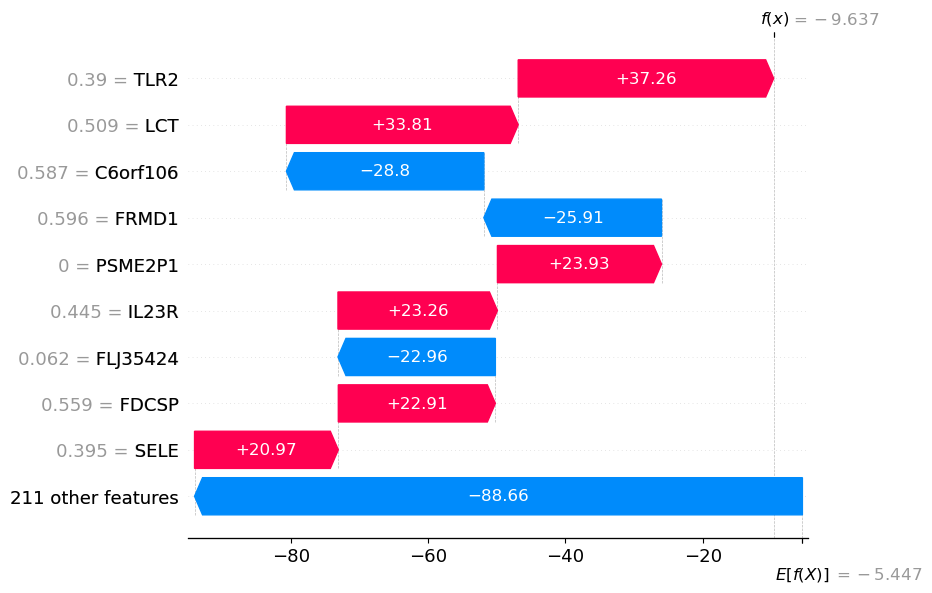

In [429]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))